### Coding by hand
Building VAE w/ and w/o Linears

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import tqdm

In [34]:
class VAE(nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, latent_size),
            nn.LeakyReLU(),
        )
        self.mu = nn.Linear(latent_size, latent_size)
        self.logvar = nn.Linear(latent_size, latent_size)

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 512),
            nn.LeakyReLU(),
            nn.Linear(512, input_size),
            nn.Sigmoid()
        )

    def reparemetrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)

        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu, logvar = self.mu(encoded), self.logvar(encoded)
        z = self.reparemetrize(mu, logvar)
        x_hat = self.decoder(z)

        return x_hat, mu, logvar

In [35]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [7]:
#creating a dataloader for the hand dataset
#using the torchvision library to transform the images from 218x178 to 64x64
IMG_SIZE = 128
BATCH_SIZE = 32
LATENT_SIZE = 32
transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)), transforms.ToTensor(), transforms.Normalize(0, 1)])
trainset = datasets.ImageFolder(root='./Data', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

trainset_2 = torch.utils.data.Subset(trainset, range(0, round(len(trainset)*0.7)))
print(len(trainset))
print(len(trainset_2))
trainloader_2 = torch.utils.data.DataLoader(trainset_2, batch_size=BATCH_SIZE, shuffle=True)

202599
141819


torch.Size([32, 3, 128, 128])


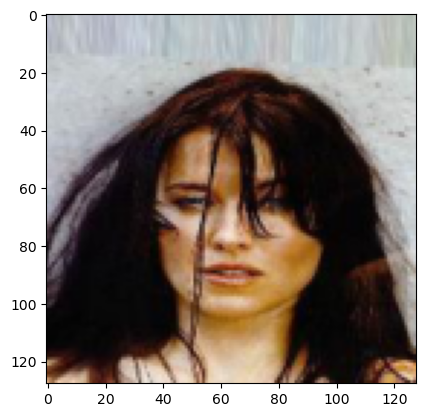

In [12]:
print(next(iter(trainloader))[0].shape)
plt.imshow(next(iter(trainloader))[0][5].permute(1, 2, 0))
#get dataloader number of batches
# len(trainloader)

In [42]:
model = VAE(input_size=3*IMG_SIZE*IMG_SIZE, latent_size=LATENT_SIZE).to(device)
print(model)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=49152, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (mu): Linear(in_features=32, out_features=32, bias=True)
  (logvar): Linear(in_features=32, out_features=32, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=512, out_features=49152, bias=True)
    (5): Sigmoid()
  )
)


In [43]:
# def elbo(x_hat, x, mu, logvar, beta_loss=1):
#     rec_loss = nn.MSELoss()(x_hat, x)
#     kl_div = - 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return rec_loss + beta_loss*kl_div
rec_loss = nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [44]:
def train(model, dataloader, optimizer, device=device, beta=1, epoch=1):
    model.train()
    flat = nn.Flatten()
    for batch_idx, (x, _) in enumerate(dataloader):
        optimizer.zero_grad()
        x = x.to(device)
        x = flat(x)
        pred, mu, logvar = model(x)
        reconstruction_loss = rec_loss(pred, x)
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = reconstruction_loss + beta *kl_divergence
        loss.backward()
        optimizer.step()
        if loss.item() >= 100:
            print(f"Loss: {loss.item()} || Rec_loss: {reconstruction_loss} || KL_div: {kl_divergence}")
        if loss.isnan().item():
            print('LOSS NAN')
            print(f"Loss: {loss.item()} || Rec_loss: {reconstruction_loss} || KL_div: {kl_divergence}")
            return "NaN"
        if batch_idx % 100 == 0 or batch_idx/len(dataloader) == 1:
            print(f'Epoch: {epoch}, Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}')


In [45]:
train(model, trainloader, optimizer)

Epoch: 1, Batch [0/6332], Loss: 8.3743
Epoch: 1, Batch [100/6332], Loss: 1.9204
Epoch: 1, Batch [200/6332], Loss: 0.5205
Epoch: 1, Batch [300/6332], Loss: 0.2550
Epoch: 1, Batch [400/6332], Loss: 0.2287
Epoch: 1, Batch [500/6332], Loss: 0.2011
Epoch: 1, Batch [600/6332], Loss: 0.1614
Epoch: 1, Batch [700/6332], Loss: 0.1636
Epoch: 1, Batch [800/6332], Loss: 0.1511
Epoch: 1, Batch [900/6332], Loss: 0.1308
Epoch: 1, Batch [1000/6332], Loss: 0.1566
Epoch: 1, Batch [1100/6332], Loss: 0.1143
Epoch: 1, Batch [1200/6332], Loss: 0.1371
Epoch: 1, Batch [1300/6332], Loss: 0.1341
Epoch: 1, Batch [1400/6332], Loss: 0.1329
Epoch: 1, Batch [1500/6332], Loss: 0.1193
Epoch: 1, Batch [1600/6332], Loss: 0.1255
Epoch: 1, Batch [1700/6332], Loss: 0.6114
Epoch: 1, Batch [1800/6332], Loss: 0.1393
Epoch: 1, Batch [1900/6332], Loss: 0.1170
Epoch: 1, Batch [2000/6332], Loss: 0.1108
Epoch: 1, Batch [2100/6332], Loss: 0.1119
Epoch: 1, Batch [2200/6332], Loss: 0.1267
Epoch: 1, Batch [2300/6332], Loss: 0.1187
Epoc

In [1]:
def generate(model, num_samples, latent_size=32):
    latent = torch.randn(num_samples, latent_size)
    latent = latent.to(device)
    samples = model.decoder(latent)
    return samples

num_samples = 16
samples = generate(model, num_samples=num_samples)
samples = samples.reshape(num_samples, IMG_SIZE, IMG_SIZE, 3)
samples = samples.detach().cpu().numpy()

plt.figure(figsize=(8,8))
for i in range(num_samples):
    plt.subplot(4, 4, i+1)
    plt.imshow(samples[i].reshape(IMG_SIZE, IMG_SIZE, 3))
    plt.xticks(visible=False)
    plt.yticks(visible=False)

NameError: name 'model' is not defined

In [106]:
## Hyperparam tunning
hyp = {"learning_rate" : [1e-3, 1e-4, 1e-5, 1e-6],
        "batch_size" : [16, 32, 64]
        "latent_size" : [32, 64]
       }
hyp

{'learning_rate': [0.1, 0.001, 0.0001, 1e-05],
 'batch_size': [16, 32, 64],
 'img_size': [64, 128, 256],
 'channels': [1, 3],
 'latent_size': [16, 32]}

In [108]:
#Testing will be in order of hyp dict
for i in hyp['learning_rate']:
    print(i)

0.1
0.001
0.0001
1e-05


In [109]:
# #OG params

IMG_SIZE = 128
BATCH_SIZE = 16
CHANNELS = 1
LATENT_SIZE = 16
learning_rate = 3e-4
beta = 1

transform = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)), transforms.ToTensor(), transforms.Grayscale(num_output_channels=CHANNELS)])
trainset = datasets.ImageFolder(root='./Data', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

INPUT_SIZE = IMG_SIZE*IMG_SIZE*CHANNELS
model = VAE(input_size=INPUT_SIZE, latent_size=LATENT_SIZE).to(device)
print(model)

rec_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#train(model, trainloader, optimizer)


VAE(
  (encoder): Sequential(
    (0): Linear(in_features=16384, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=8192, out_features=4096, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=4096, out_features=16, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (mu): Linear(in_features=16, out_features=16, bias=True)
  (logvar): Linear(in_features=16, out_features=16, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=4096, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=4096, out_features=8192, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=8192, out_features=16384, bias=True)
    (5): Sigmoid()
  )
)


In [110]:
#Testing will be in order of hyp dict
def train(model, dataloader, optimizer, device=device, beta=1, epoch=1):
    model.train()
    flat = nn.Flatten()
    for batch_idx, (x, _) in enumerate(dataloader):
        optimizer.zero_grad()
        x = x.to(device)
        x = flat(x)
        pred, mu, logvar = model(x)
        reconstruction_loss = rec_loss(pred, x)
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = reconstruction_loss + beta *kl_divergence
        loss.backward()
        optimizer.step()
        if loss.item() >= 100:
            print(f"Loss: {loss.item()} || Rec_loss: {reconstruction_loss} || KL_div: {kl_divergence}")
        if loss.isnan().item():
            print('LOSS NAN')
            print(f"Loss: {loss.item()} || Rec_loss: {reconstruction_loss} || KL_div: {kl_divergence}")
            return "NaN"
        if batch_idx % 100 == 0 or batch_idx/len(dataloader) == 1:
            print(f'Model: {model} || Epoch: {epoch}, Batch [{batch_idx}/{len(dataloader)}], Loss: {loss.item():.4f}')

models = []
for i in hyp['learning_rate']:
    print(i)
    model_name = f"model_lr_{i}"
    model_name = VAE(input_size=INPUT_SIZE, latent_size=LATENT_SIZE).to(device)
    optimizer = torch.optim.Adam(model_name.parameters(), lr=i)
    _ = train(model_name, trainloader_10, optimizer)
    models.append(model_name)

0.1
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=16384, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=8192, out_features=4096, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=4096, out_features=16, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
  )
  (mu): Linear(in_features=16, out_features=16, bias=True)
  (logvar): Linear(in_features=16, out_features=16, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=4096, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=4096, out_features=8192, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=8192, out_features=16384, bias=True)
    (5): Sigmoid()
  )
)
Epoch: 1, Batch [0/1267], Loss: 4.5971
LOSS NAN
Loss: nan || Rec_loss: nan || KL_div: inf
0.001
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=16384, out_features=8192, bias=True)
    (1): LeakyReL

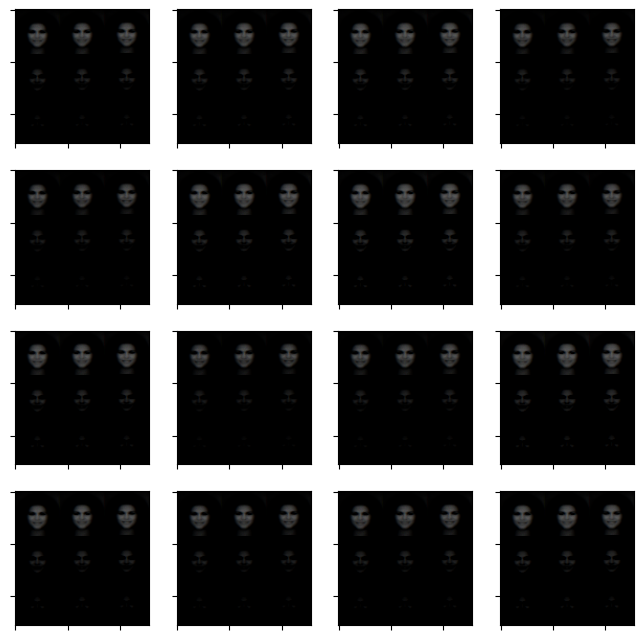

In [33]:
def generate(model, num_samples, latent_size=32):
    latent = torch.randn(num_samples, latent_size)
    latent = latent.to(device)
    samples = model.decoder(latent)
    return samples

num_samples = 16
samples = generate(model, num_samples=num_samples)
samples = samples.reshape(num_samples, IMG_SIZE, IMG_SIZE, 3)
samples = samples.detach().cpu().numpy()

plt.figure(figsize=(8,8))
for i in range(num_samples):
    plt.subplot(4, 4, i+1)
    plt.imshow(samples[i].reshape(IMG_SIZE, IMG_SIZE, 3))
    plt.xticks(visible=False)
    plt.yticks(visible=False)

In [ ]:
# Grad clipping: https://saturncloud.io/blog/how-to-do-gradient-clipping-in-pytorch/#:~:text=Gradient%20clipping%20is%20a%20technique,converge%20to%20a%20good%20solution.